In [1]:
import os                                               #os interface library 
import requests                                         #HTTP requests library
import pandas as pd                                     #panda library
from dotenv import load_dotenv                          #dotenv library to read keys and secrect key for api
import alpaca_trade_api as trade_api                     #Alpaca library
from MCForecastTools import MCSimulation                #Monta Carlos simulation apis
import json                                             #JSON library ro work with JSON objects
from datetime import date                               #Data-Time library

#set the backend of matplotlib to the 'inline' backend 
%matplotlib inline 
# Load .env enviroment variables
load_dotenv()
True
def setting_api():
    alpaca_api_key=os.getenv("ALPACA_API_KEY")
    alpaca_secret_key=os.getenv("ALPACA_SECRET_KEY")
    alpaca = trade_api.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')
    return alpaca
    

In [2]:
# # Function for retrieving data relative to tickers/portfolio
def portfolio_data(tickers):
    today = date.today() + pd.DateOffset(years=-5)                        
    today = pd.Timestamp(today, tz="America/New_York").isoformat()  
    timeframe ='1Day'
    portfolio =alpaca.get_bars(tickers,timeframe,start=today,adjustment='raw').df
    portfolio.index = portfolio.index.date
    return portfolio
# function for retrieving data related to benchmark:
def bench_mark(symbol):
    bench_mark = portfolio_data(symbol)
    symbol = bench_mark[['close']].rename(columns = {'close': symbol})
    return symbol
# function to seperate the required data :
def format_data(symbol):
    ticker =portfolio[portfolio["symbol"]==symbol].drop("symbol", axis=1)
    closing_price = ticker[['close']]
    closing_price = closing_price.rename(columns={'close' : symbol})
    return closing_price
# function for calculating cuumulative returns:
def cumulative_returns(data):
    data_returns = data.pct_change()
    data_cumulative = (1+data_returns).cumprod()
    return data_cumulative
# function for equally weghting stocks:
def equal_weights(data):
    weights = []
    for i in range(0,len(portfolio.columns)):
        w = 1/len(portfolio.columns)
        weights.append(w)
    return weights   


In [4]:
alpaca = setting_api()
tickers = ['APD', 'APH', 'RACE', 'TEL', 'IFF', 'GLW']
portfolio = portfolio_data(tickers)
portfolio.head()


,open,high,low,close,volume,trade_count,vwap,symbol
2017-04-13,135.33,135.5800,134.17,134.30,626943,7518,134.705681,APD
2017-04-17,134.78,135.8950,134.42,135.86,1092375,11416,135.497295,APD
2017-04-18,135.04,136.0200,134.72,135.27,701020,10116,135.259170,APD
2017-04-19,135.73,136.0399,134.78,134.96,577819,7170,135.166924,APD
2017-04-20,135.62,137.3400,135.20,136.90,985329,10779,136.676759,APD


In [5]:
apd =format_data('APD')
aph =format_data('APH')
race=format_data('RACE')
tel=format_data('TEL')
iff=format_data('IFF')
glw=format_data('GLW')
apd.head()

,APD
2017-04-13,134.30
2017-04-17,135.86
2017-04-18,135.27
2017-04-19,134.96
2017-04-20,136.90


In [6]:
portfolio = pd.concat([apd,aph,race,tel,iff,glw],axis =1,join = 'inner')
portfolio.head()

,APD,APH,RACE,TEL,IFF,GLW
2017-04-13,134.30,68.65,70.63,71.93,131.94,26.32
2017-04-17,135.86,69.53,71.32,72.77,133.02,26.54
2017-04-18,135.27,69.96,70.59,73.08,134.07,26.89
2017-04-19,134.96,70.12,71.26,73.18,134.53,26.86
2017-04-20,136.90,70.82,71.40,74.12,135.80,27.11


In [7]:
spy = bench_mark('SPY')
spy.head()

,SPY
2017-04-13,232.51
2017-04-17,234.57
2017-04-18,233.87
2017-04-19,233.44
2017-04-20,235.34


<AxesSubplot:>

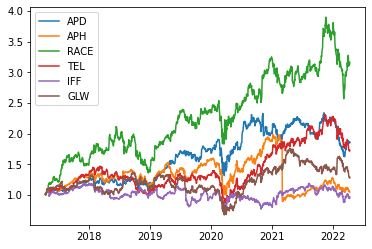

In [8]:
spy_cumulative = cumulative_returns(spy)
portfolio_cumulative = cumulative_returns(portfolio)
portfolio_cumulative.plot()

<AxesSubplot:>

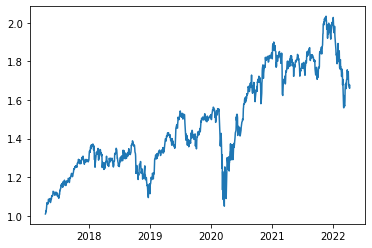

In [9]:
weights = equal_weights(portfolio)
portfolio_price_action = portfolio_cumulative.dot(weights)
portfolio_price_action.plot()

<AxesSubplot:>

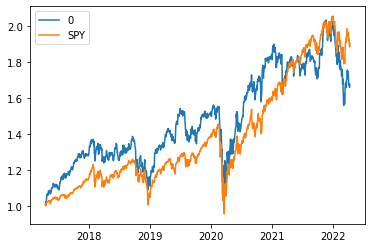

In [10]:
comparison = pd.concat([portfolio_price_action,spy_cumulative],axis = 1 ,join = 'inner')
comparison.plot()